## Artificial Neural Network 

#####  * I am trying to cover the basic conncepts of Deep learning 

In [2]:
## Libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

##### Utility Functions
These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [3]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

Logistic Regression 

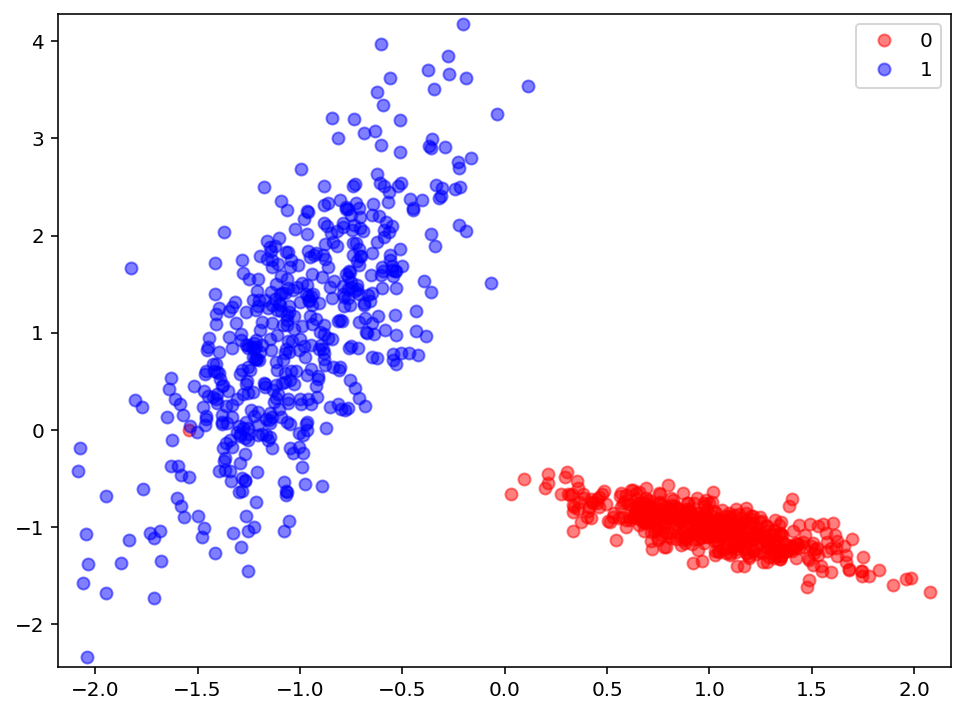

In [4]:
## Linearly Separable Data

##2 dimensional linearly separable data. We are using the scikit-learn make_classification method to generate our data and use our helper function defined above to visualize it.
x, y = make_classification(n_samples= 1000,n_features=2,n_redundant=0,n_informative=2, random_state=7 , n_clusters_per_class=1)
plot_data(x,y)

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


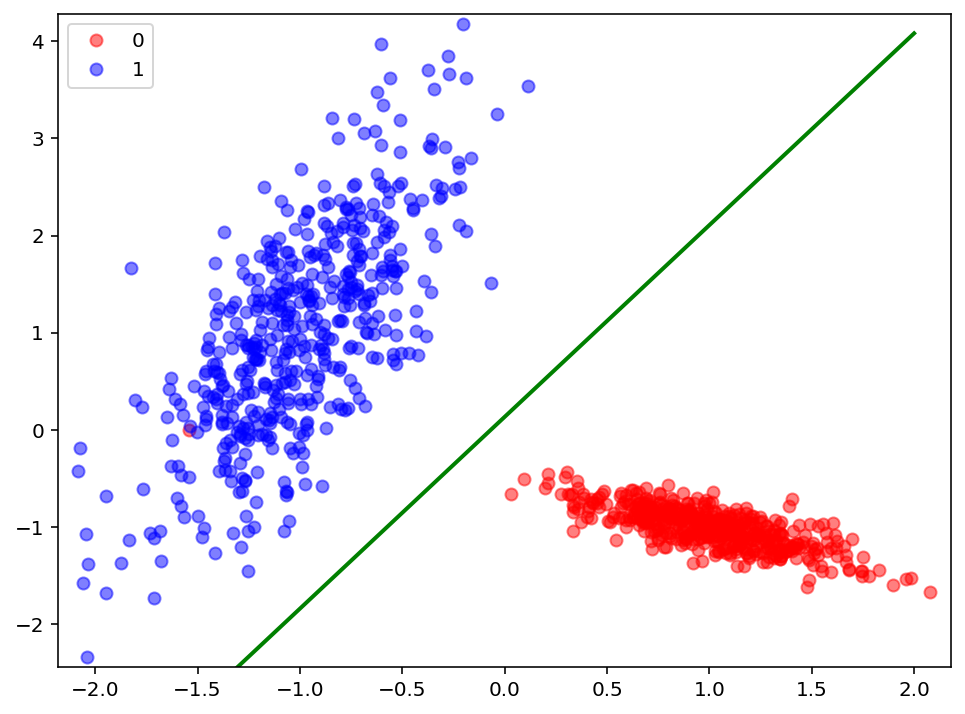

In [5]:
##fiting our data in logistic regression 
lr = LogisticRegression()
lr.fit(x,y)
 
plot_data(x,y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

limits = np.array([-2,2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

Binary Classification using Keras library

* The Dense function in Keras constructs a fully connected neural network layer, automatically initializing the weights as biases. It's a super useful function that you will see everywhere. The function arguments are defined as follows:

* units: The first argument, the number of nodes in this layer. Since we're constructing the output layer, and we said it has only one node, this value is 1.
* input_shape: The first layer in Keras models need to specify the input dimensions. The subsequent layers (which we don't have here ) don't need to specify this argument because Keras can infer their dimensions automatically. In this our input dimensionality is 2, the x and y coordinates. The input_shape parameter expects a vector, so in our case it's simply a tuple with one number.
* activation: The activation function of a logistic regression model is the logistic function, or altenatively called as sigmoid. 

In [6]:
### in our we build deep neural network we can use Sequential model API , the sequential model allows us to build deep neural network by stacking layers one top of another

model = Sequential()
model.add(Dense(units=1,input_shape =(2,),activation='sigmoid'))

2022-05-30 15:19:20.500179: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-30 15:19:20.500219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iamismail-desktop): /proc/driver/nvidia/version does not exist
2022-05-30 15:19:20.500810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



After we build our model we need to compile the model , this will create the neural network model by configuring the learning process , be know in here the model hasn't been trained yet , Just in here we will specifying the optimizer to use and the loss function to minimize . the arguments are defined below 

* optimizer: Which optimizer to use in order to minimize the loss function. There are a lot of different optimizers, most of them based on gradient descent. Now we will use adam optimizer   
* loss: The loss function to minimize. Since we're building a binary 0/1 classifier, the loss function to minimize is binary_crossentropy. 
* metrics: Which metric to report statistics on, for classification problems we set this as accuracy.

In [7]:
## Compiling the model 
model.compile (optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


### Training the model 

In [8]:
history  = model.fit(x=x, y=y, verbose=0 , epochs=50)

KeyError: 'acc'

<Figure size 576x432 with 0 Axes>

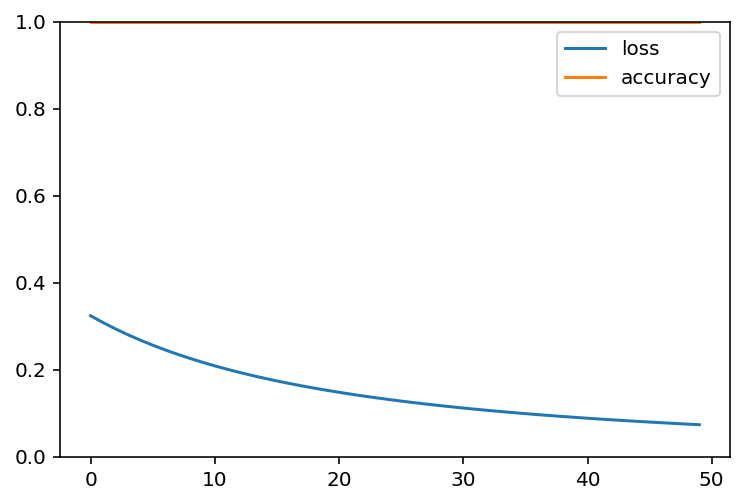

In [9]:
plot_loss_accuracy(history)

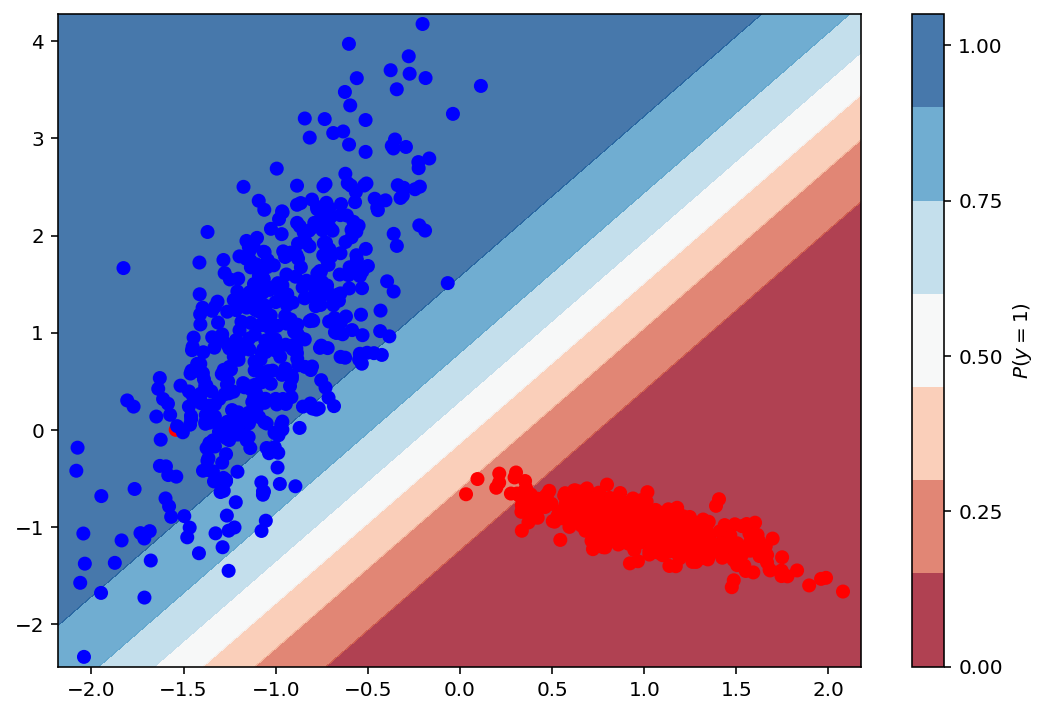

In [ ]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

Complex Data - Moons

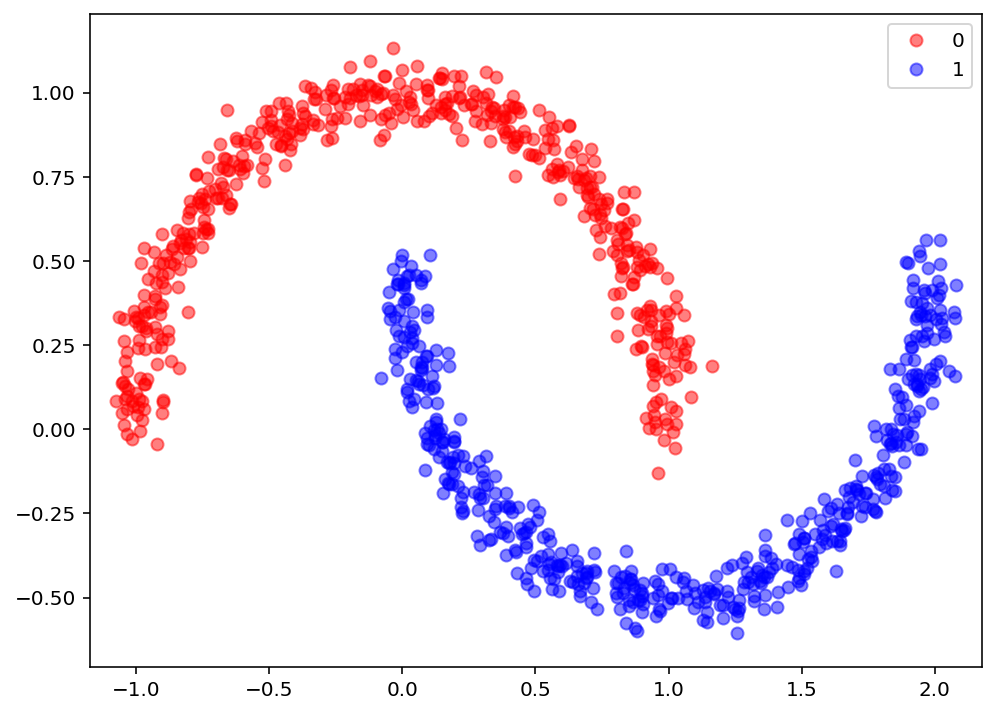

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

KeyError: 'acc'

<Figure size 576x432 with 0 Axes>

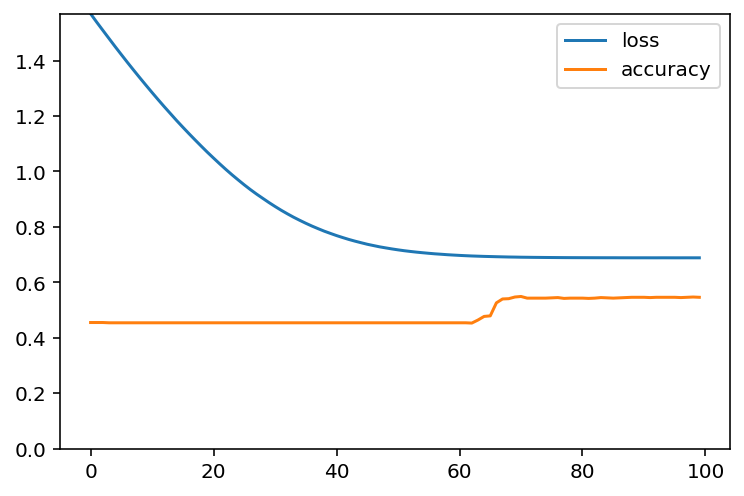

In [ ]:
anthrmodel = Sequential()
anthrmodel.add(Dense(1, input_shape=(2,), activation='sigmoid'))

anthrmodel.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = anthrmodel.fit(x, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

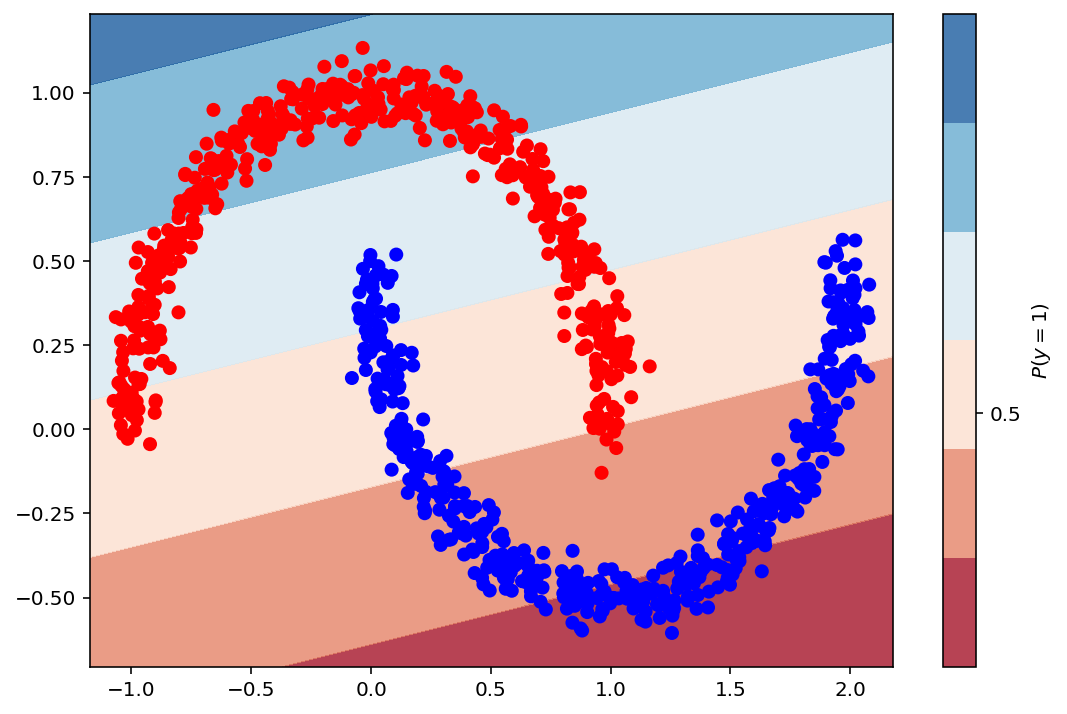

In [ ]:
plot_decision_boundary(lambda x: anthrmodel.predict(x), X, y)

#### Multiclass Classification
In previous section we have tried on binary classification , Nowe i will take a look at multi class classficaiton 

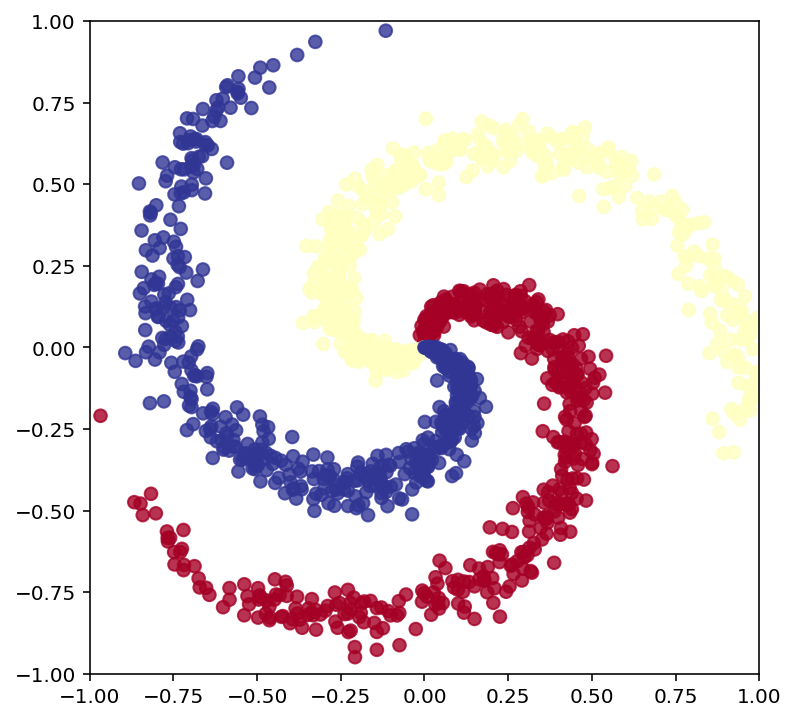

In [ ]:
X2, y2 = make_multiclass(K=3)

#### Softmax Regression
As we saw above, Logistic Regression (LR) is a classification method for 2 classes. It works with binary labels 0/1. Softmax Regression (SR) is a generalization of LR where we can have more than 2 classes. In our current dataset we have 3 classes, represented as 0/1/2.

Building the model for SR is very similar to LR, for reference here’s how we built our Logistic Regression model.

In [ ]:
model= Sequential()
model.add(Dense(3, input_shape =(2,),activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## in softmax regression in fit function we need that our lables to be in onehotenocded 
y_cat = to_categorical(y2)
history = model.fit(X2,y_cat,epochs=20)

Epoch 1/20
47/47 [==============================] - 0s 507us/step - loss: 1.1847 - accuracy: 0.3147
Epoch 2/20
47/47 [==============================] - 0s 479us/step - loss: 1.1669 - accuracy: 0.3020
Epoch 3/20
47/47 [==============================] - 0s 454us/step - loss: 1.1497 - accuracy: 0.3000
Epoch 4/20
47/47 [==============================] - 0s 428us/step - loss: 1.1331 - accuracy: 0.2987
Epoch 5/20
47/47 [==============================] - 0s 446us/step - loss: 1.1171 - accuracy: 0.3000
Epoch 6/20
47/47 [==============================] - 0s 430us/step - loss: 1.1018 - accuracy: 0.3053
Epoch 7/20
47/47 [==============================] - 0s 418us/step - loss: 1.0869 - accuracy: 0.3120
Epoch 8/20
47/47 [==============================] - 0s 466us/step - loss: 1.0727 - accuracy: 0.3193
Epoch 9/20
47/47 [==============================] - 0s 453us/step - loss: 1.0589 - accuracy: 0.3253
Epoch 10/20
47/47 [==============================] - 0s 405us/step - loss: 1.0457 - accuracy: 0.3327

KeyError: 'acc'

<Figure size 576x432 with 0 Axes>

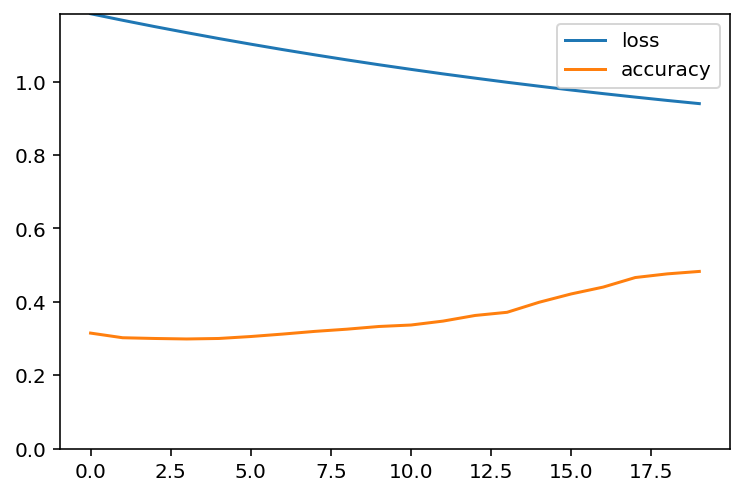

In [ ]:
plot_loss_accuracy(history)

#### In summary 

* There are couple difference between Logistic Regression and Softmax Regression 
     * In Logistic regression number of nodes in dense layers are 1 node , while Softmax regression the number of nodes in dense layer are 3 since we have 3 classes 
     * In Activation function  , Linear regresion we used sigmoid activation function while Softmax regression we use softmax activation function , Softmax scales the values of the output nodes such that they represent probabilites and sum up to 1 
     * Loss function , In linear regression in loss function we use binary_crossentropy , in multiclass (softmax regression ) the loss function is categorical crossentropy , Categorical crossentripy is binary crossentropy more than 2 classes 
     * Fit function : In linear regression directly we fit our data , while in softmax regression the labels need to be in one hot representation 

#### Artificial Neural Network 
- Let's train deep artificial neural network to better classify the datasets which the logistic regression struggled 
-This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:

* Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
* Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
* We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.

KeyError: 'acc'

<Figure size 576x432 with 0 Axes>

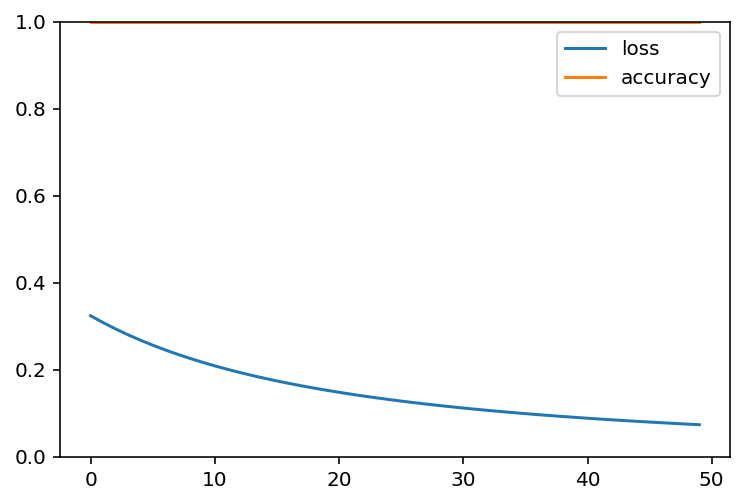

In [14]:
## ANN Model 
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
annmodel = Sequential()
annmodel.add(Dense(4, activation='tanh',input_shape=(2,)))
annmodel.add(Dense(2, activation='tanh'))
annmodel.add(Dense(1,activation='sigmoid'))


annmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
histroy = annmodel.fit(X,y, verbose=0,epochs=100)
plot_loss_accuracy(history)

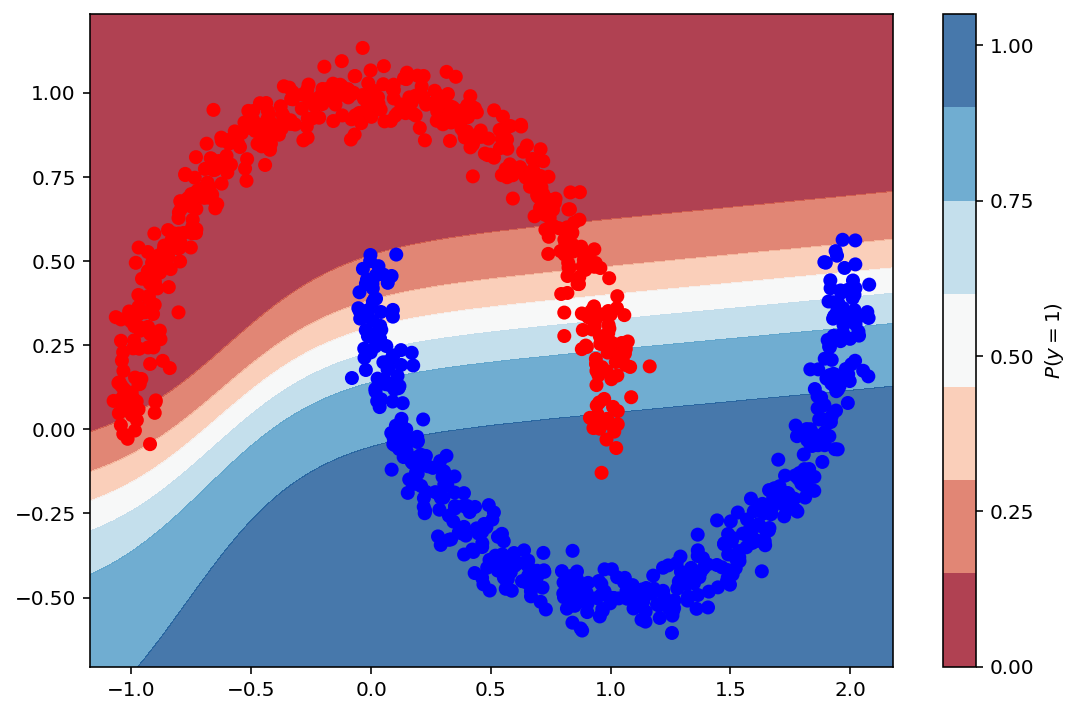

In [15]:
plot_decision_boundary(lambda x:annmodel.predict(x),X,y)